# Horse or Human - Image Augmentation

In [1]:
%load_ext autoreload 
%autoreload 2

## Install `tfutils`


In [4]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tfutils
import glob

## Download Data

### Train data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/train-horse-or-human.zip

--2021-07-23 09:02:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/train-horse-or-human.zip’

/tmp/train-horse-or 100%[===================>] 142.65M   167MB/s    in 0.9s    

2021-07-23 09:02:46 (167 MB/s) - ‘/tmp/train-horse-or-human.zip’ saved [149574867/149574867]



### Test data


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/test-horse-or-human.zip

--2021-07-23 09:02:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 108.177.11.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/test-horse-or-human.zip’

/tmp/test-horse-or- 100%[===================>]  10.95M  --.-KB/s    in 0.1s    

2021-07-23 09:02:48 (84.5 MB/s) - ‘/tmp/test-horse-or-human.zip’ saved [11480187/11480187]



In [5]:
import os
import zipfile


for subset in ['train', 'test']:
    local_zip = f'/tmp/{subset}-horse-or-human.zip'
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(f'/tmp/{subset}-horse-or-human')


In [6]:
DATA_DIR = {subset: f'/tmp/{subset}-horse-or-human/' for subset in ['train', 'test']}

### Structure of the directory

In [7]:
os.listdir(DATA_DIR['train'])

['horses', 'humans']

In [8]:
for cls_name in os.listdir(DATA_DIR['train']):
    print(cls_name)
    print('-'*10)
    print(os.listdir(os.path.join(DATA_DIR['train'], cls_name)))
    print()

horses
----------
['horse09-9.png', 'horse17-0.png', 'horse30-4.png', 'horse04-1.png', 'horse12-5.png', 'horse20-5.png', 'horse32-2.png', 'horse08-6.png', 'horse48-5.png', 'horse15-1.png', 'horse25-8.png', 'horse33-5.png', 'horse02-1.png', 'horse04-0.png', 'horse29-5.png', 'horse01-0.png', 'horse01-2.png', 'horse44-0.png', 'horse15-9.png', 'horse49-8.png', 'horse14-2.png', 'horse16-4.png', 'horse42-4.png', 'horse32-0.png', 'horse19-6.png', 'horse50-4.png', 'horse36-1.png', 'horse29-0.png', 'horse37-3.png', 'horse24-9.png', 'horse48-8.png', 'horse18-7.png', 'horse27-4.png', 'horse15-6.png', 'horse01-3.png', 'horse02-2.png', 'horse29-6.png', 'horse35-8.png', 'horse50-2.png', 'horse20-0.png', 'horse29-8.png', 'horse26-4.png', 'horse18-5.png', 'horse19-3.png', 'horse30-9.png', 'horse24-8.png', 'horse44-3.png', 'horse16-6.png', 'horse06-9.png', 'horse16-9.png', 'horse12-1.png', 'horse07-1.png', 'horse12-3.png', 'horse45-9.png', 'horse11-8.png', 'horse09-3.png', 'horse35-0.png', 'horse34-8.p

In [9]:
CLASS_NAMES = sorted(os.listdir(DATA_DIR['train']))

In [10]:
DATA_FILES = {cls_name : {} for cls_name in CLASS_NAMES}


for cls_name in CLASS_NAMES:
    for subset in ['train', 'test']:
        dirpath = os.path.join(DATA_DIR[subset], cls_name)
        DATA_FILES[cls_name][subset] = glob.glob(dirpath + '/*')



## Visualize some images

In [11]:
import matplotlib.image as mpimg

In [12]:
num_images = 4
num_classes = 2
subset = 'train'
dir_idx = 0

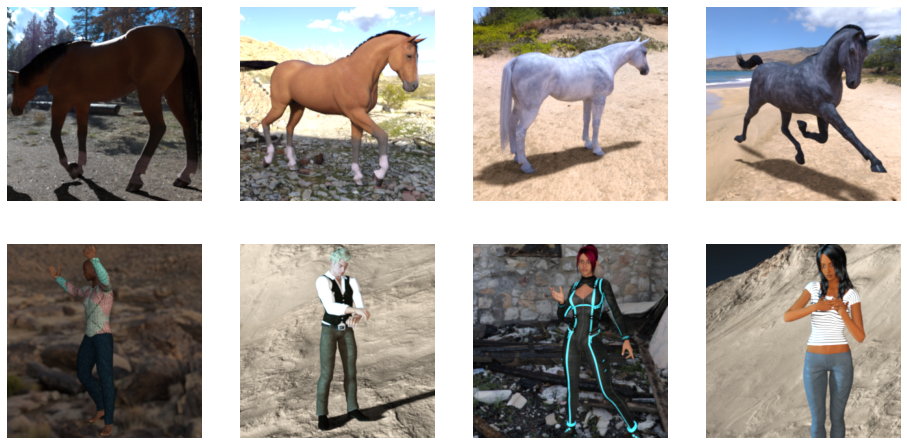

In [13]:
fig, axn = plt.subplots(num_classes, num_images, figsize=(num_images*4, num_classes*4))

for cls_name, row in zip(CLASS_NAMES, axn):
    idx = 0
    for ax in row:
        data_file = DATA_FILES[cls_name][subset][dir_idx + idx]
        img = mpimg.imread(data_file)
        ax.imshow(img)

        ax.grid(False)
        ax.set_axis_off()

        idx += 1


dir_idx += idx



In [64]:
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tfutils.visualize import plot_learning_curve
from sklearn import metrics as skmetrics

## Some Global Variables

In [15]:
TARGET_IMG_SHAPE = (300, 300)
NUM_CHANNELS = 3
INPUT_SHAPE = (*TARGET_IMG_SHAPE, NUM_CHANNELS)
N_CLASSES = 2 
BATCH_SIZE = 128
CLASSIFICATION_TYPE = 'binary'
RANDOM_STATE = 42
VALIDATION_SPLIT = 0.2

In [69]:
TFMODELS = {}
PREDICTIONS = {'train': {}, 'test': {}}

## Model 1: simple-cnn

In [70]:
model_name = 'simple-cnn'

In [71]:
model = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "simple-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 33, 33, 64)        3

### Preprocess the data


In [72]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [73]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [74]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Fit the model

In [75]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
26/26 [==============================] - 8s 283ms/step - loss: 0.6095 - accuracy: 0.6910 - val_loss: 0.5420 - val_accuracy: 0.7902
Epoch 2/15
26/26 [==============================] - 7s 270ms/step - loss: 0.3683 - accuracy: 0.8662 - val_loss: 0.3043 - val_accuracy: 0.9561
Epoch 3/15
26/26 [==============================] - 7s 270ms/step - loss: 0.2141 - accuracy: 0.9258 - val_loss: 0.2754 - val_accuracy: 0.9073
Epoch 4/15
26/26 [==============================] - 7s 265ms/step - loss: 0.1441 - accuracy: 0.9513 - val_loss: 0.1774 - val_accuracy: 0.9512
Epoch 5/15
26/26 [==============================] - 7s 270ms/step - loss: 0.1079 - accuracy: 0.9647 - val_loss: 0.2524 - val_accuracy: 0.8585
Epoch 6/15
26/26 [==============================] - 7s 273ms/step - loss: 0.0800 - accuracy: 0.9745 - val_loss: 0.1112 - val_accuracy: 0.9512
Epoch 7/15
26/26 [==============================] - 7s 279ms/step - loss: 0.0630 - accuracy: 0.9818 - val_loss: 0.1170 - val_accuracy: 0.9561
Epoch 

### Learning Curve

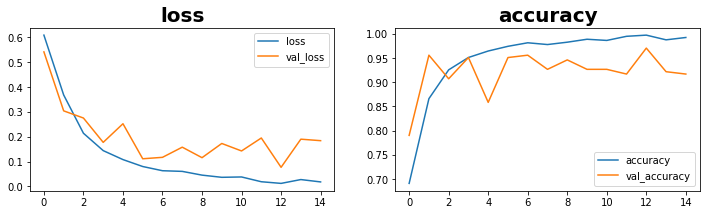

In [76]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [77]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

## Model 2: simple-cnn-dropout

In [79]:
model_name = 'simple-cnn-dropout'

In [80]:
model = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "simple-cnn-dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 71, 71, 64) 

### Preprocess the data


In [81]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [82]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [83]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Fit the model

In [84]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
26/26 [==============================] - 8s 284ms/step - loss: 0.6479 - accuracy: 0.6046 - val_loss: 0.6674 - val_accuracy: 0.8195
Epoch 2/15
26/26 [==============================] - 7s 267ms/step - loss: 0.5154 - accuracy: 0.7603 - val_loss: 0.6223 - val_accuracy: 0.8293
Epoch 3/15
26/26 [==============================] - 7s 266ms/step - loss: 0.3819 - accuracy: 0.8431 - val_loss: 0.5211 - val_accuracy: 0.8488
Epoch 4/15
26/26 [==============================] - 7s 266ms/step - loss: 0.2802 - accuracy: 0.8869 - val_loss: 0.4885 - val_accuracy: 0.8780
Epoch 5/15
26/26 [==============================] - 7s 274ms/step - loss: 0.1829 - accuracy: 0.9246 - val_loss: 0.4597 - val_accuracy: 0.8683
Epoch 6/15
26/26 [==============================] - 7s 271ms/step - loss: 0.1339 - accuracy: 0.9635 - val_loss: 0.3750 - val_accuracy: 0.9220
Epoch 7/15
26/26 [==============================] - 7s 267ms/step - loss: 0.1150 - accuracy: 0.9513 - val_loss: 0.3883 - val_accuracy: 0.8683
Epoch 

### Learning Curve

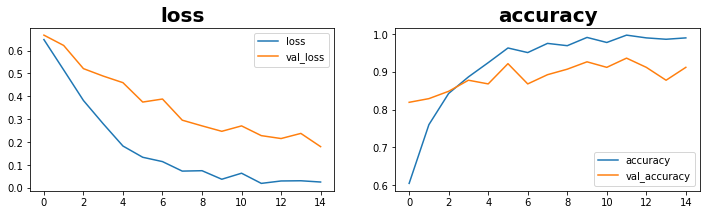

In [85]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [86]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

### Comparing the two models

In [90]:
from tfutils.evaluate import ClassificationPerformanceComparer

preds = PREDICTIONS['test']
clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=list(preds.values()), data=(None, test_gen.labels),
                                                              model_names=list(preds.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()

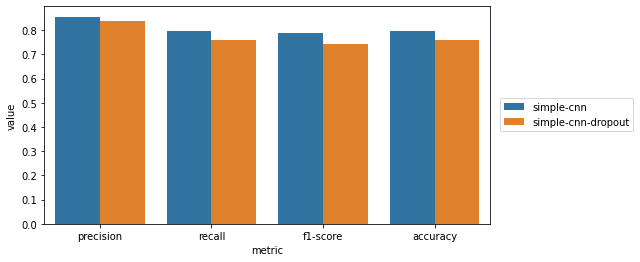

In [92]:
clf_comp.plot_metric_comparison_df()

Our Dropout model is possibly over-regularized and does not perform as good as the simple one. 

## Model 3: simple-cnn-data-aug

In [93]:
model_name = 'simple-cnn-data-aug'

In [94]:
model = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "simple-cnn-data-aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 33, 33, 64)

### Preprocess the data


In [99]:
train_datagen = ImageDataGenerator(rescale=1/255., 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=VALIDATION_SPLIT) 

validation_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [100]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [101]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = validation_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Fit the model

In [102]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
26/26 [==============================] - 22s 802ms/step - loss: 0.6795 - accuracy: 0.5620 - val_loss: 0.6375 - val_accuracy: 0.8146
Epoch 2/15
26/26 [==============================] - 21s 806ms/step - loss: 0.6236 - accuracy: 0.6326 - val_loss: 0.4966 - val_accuracy: 0.8585
Epoch 3/15
26/26 [==============================] - 21s 810ms/step - loss: 0.5385 - accuracy: 0.7372 - val_loss: 0.3774 - val_accuracy: 0.9220
Epoch 4/15
26/26 [==============================] - 22s 840ms/step - loss: 0.5152 - accuracy: 0.7397 - val_loss: 0.4737 - val_accuracy: 0.6780
Epoch 5/15
26/26 [==============================] - 21s 823ms/step - loss: 0.4599 - accuracy: 0.7847 - val_loss: 0.3067 - val_accuracy: 0.8976
Epoch 6/15
26/26 [==============================] - 21s 818ms/step - loss: 0.4441 - accuracy: 0.8029 - val_loss: 0.2587 - val_accuracy: 0.9171
Epoch 7/15
26/26 [==============================] - 22s 828ms/step - loss: 0.3814 - accuracy: 0.8309 - val_loss: 0.2777 - val_accuracy: 0.8683

### Learning Curve

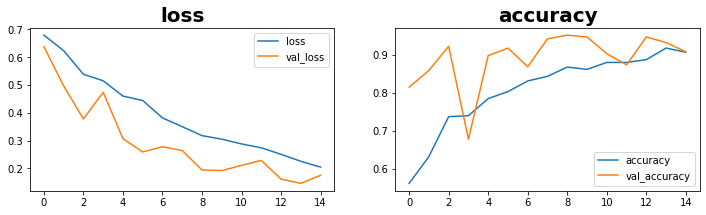

In [103]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [104]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

## Performance Comparison

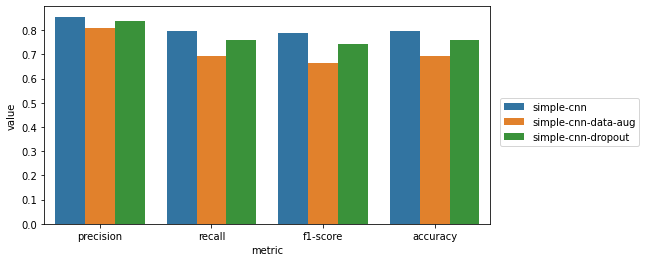

In [107]:
preds = PREDICTIONS['test']
clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=list(preds.values()), data=(None, test_gen.labels),
                                                              model_names=list(preds.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()
clf_comp.plot_metric_comparison_df()

Wow! Data Augmentation hurt our results